## Assignment-3
### Pradeep Mundlik AI21BTECH11022

In [1]:
import numpy as np
import torch
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import imageio
import cv2
%matplotlib inline


### Question-1

In [2]:
# importing images and predicting class labels

weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model.eval()
lis = []  # list to store image tensors of 5 images
labels_lis = []  # list to store labels of images

for i in range(5):
    img = read_image(f'images/i{i+1}.jpg')
    preprocess = weights.transforms()
    batch = preprocess(img).unsqueeze(0)
    lis.append(batch)
    prediction = model(batch).squeeze(0).softmax(0)
    class_id = prediction.argmax().item()
    labels_lis.append(class_id)
    score = prediction[class_id].item()
    category_name = weights.meta["categories"][class_id]
    print(f'category_name:{category_name}, score:{score}')


category_name:German shepherd, score:0.31197068095207214
category_name:rock python, score:0.280105322599411
category_name:steel drum, score:0.6231425404548645
category_name:desk, score:0.13517935574054718
category_name:tiger cat, score:0.10515560954809189


In [3]:
# converting list of images to data matrix
data = torch.concat(lis, dim=0)
print(data.shape)


torch.Size([5, 3, 224, 224])


#### a: Vanilla 

In [4]:
grad = None
# hook to store gradients


def hook_backprop(module, grad_input, grad_output):
    global grad
    grad = grad_input[0]
    return (grad,)


In [5]:
# initiailzing models with default weights
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model.eval()

# accessing first layer
first_layer = list(model._modules.items())[0][1]
hook_handle = first_layer.register_full_backward_hook(hook_backprop)

batch = data
batch.requires_grad = True

# forward path
prediction = model(batch).squeeze(1).softmax(1)
q = prediction.max(1)

# backward path
loss = -1*torch.log(q.values)
loss.mean().backward(retain_graph=True)

print(grad.shape)


torch.Size([5, 3, 224, 224])


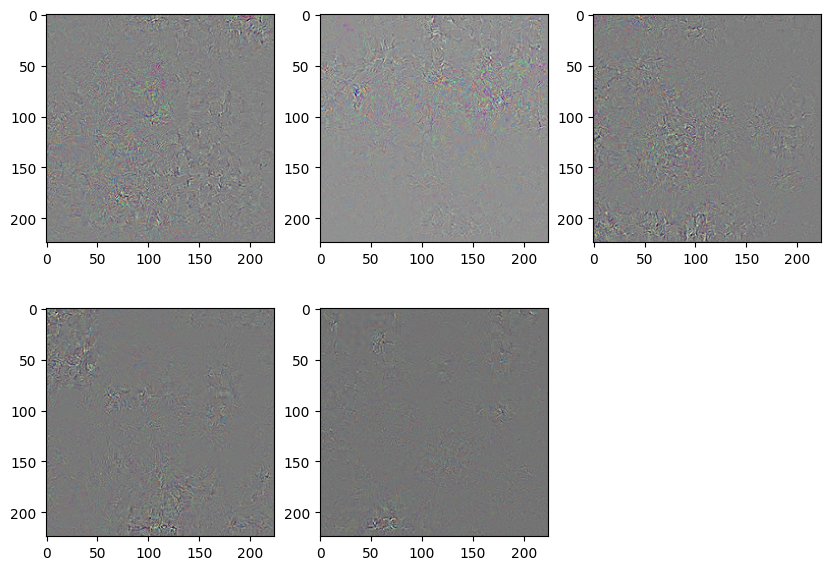

In [6]:
# plotting gradients
plt.figure(figsize=(10, 7))
for i in range(5):
    im = grad[i, :, :, :]

    # normalizing matrix
    min, max = im.min(), im.max()
    im = (im-min)/(max-min)

    plt.subplot(2, 3, i+1)
    plt.imshow(np.transpose(im, (1, 2, 0)))


#### b: Guided-back-prop

In [7]:
# hook to store gradients
def hook_backprop_guided(module, grad_input, grad_output):
    global grad
    grad = torch.maximum(grad_input[0], torch.zeros(grad_input[0].shape))
    return (grad,)


In [8]:
# accessing relu layers
for name, layer in model.named_modules():
    if 'relu' in name:
        layer.register_backward_hook(hook_backprop_guided)

# accessing first layer
first_layer = list(model._modules.items())[0][1]
hook_handle = first_layer.register_full_backward_hook(hook_backprop_guided)

# forward pass
prediction = model(batch).squeeze(1).softmax(1)
q = prediction.max(1)

# backward pass
loss = -1*torch.log(q.values)
loss.mean().backward(retain_graph=True)


/home/pradeep/.local/lib/python3.10/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


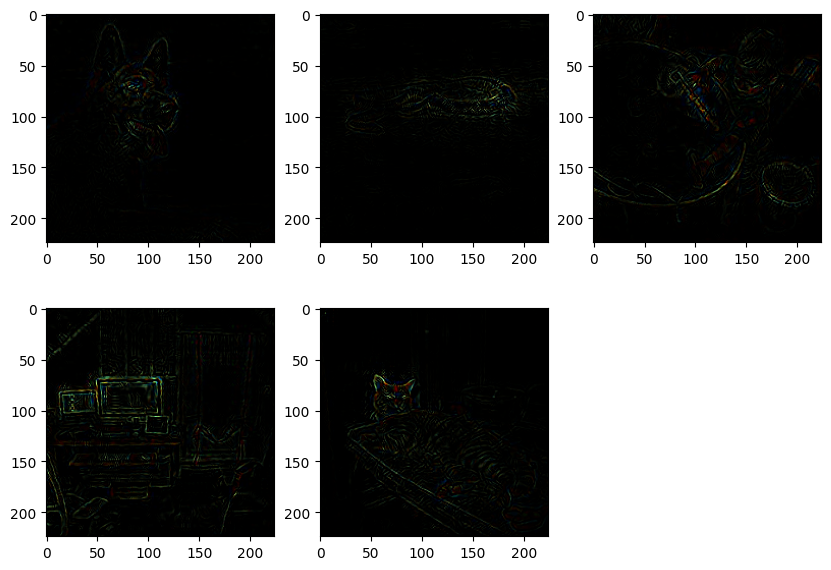

In [9]:
# plotting images
plt.figure(figsize=(10, 7))
for i in range(5):
    im = grad[i, :, :, :]
    # normalizing image tensors
    min, max = im.min(), im.max()
    im = (im-min)/(max-min)
    plt.subplot(2, 3, i+1)
    plt.imshow(np.transpose(im, (1, 2, 0)))


#### C: Class Activation Map

In [10]:
fc_grad = None

# hook to store grad_output


def hook_forwardprop(module, input, output):
    global fc_grad
    fc_grad = output[0]
    return


In [11]:
# accessing last layer
lastlayer = list(model._modules.items())[7][1][2]
hook_handle = lastlayer.register_forward_hook(hook_forwardprop)


# calling forward path
prediction = model(batch).squeeze(1).softmax(1)
class_ids = prediction.max(1).indices

# accessing weights of max probability class in final layers 
fc_weight = model.fc.weight[class_ids]
print(fc_weight.shape)
print(fc_grad.shape)

torch.Size([5, 2048])
torch.Size([2048, 7, 7])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


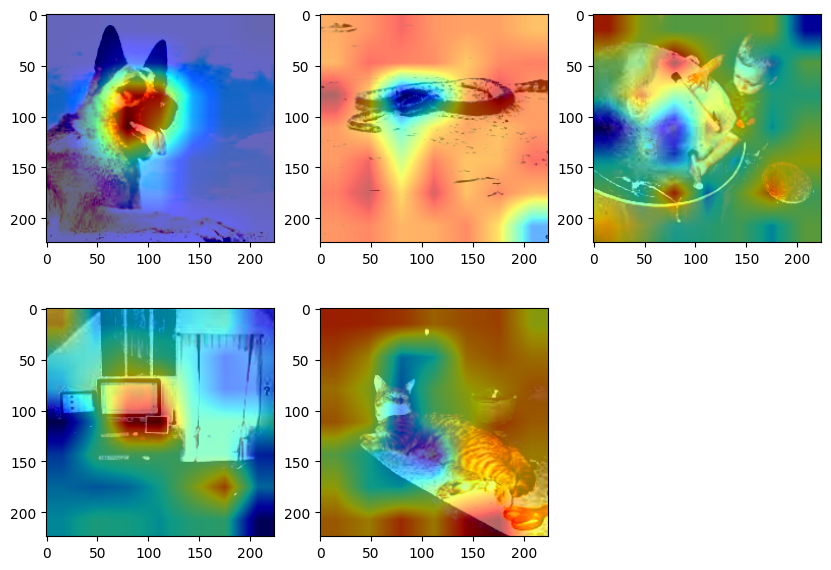

In [12]:
plt.figure(figsize=(10, 7))
for i in range(5):
    fc_ = fc_weight[i, :]
    fc_ = fc_.reshape([-1, 1])

    # converting 2048 tensor in 2048*7 tensor by concatinating same 1D tensor 7 times
    a = 7*[fc_]
    fc_ = torch.concat(a, dim=1)

    # converting 2048*7 tensor in 2048*7*7 tensor by concatinating same 2D tensor 7 times
    fc_ = fc_.reshape([2048, 7, 1])
    a = 7*[fc_]
    fc_ = torch.concat(a, dim=2)

    # element-wise multiplication and then weighted sum
    im = torch.mul(fc_, fc_grad).sum(0).detach()

    # resize and plot
    im = cv2.resize(im.numpy().astype(np.float32), (224, 224))
    plt.subplot(2, 3, i+1)
    plt.imshow(im, cmap='jet')

# plot original input images over it
for i in range(5):
    plt.subplot(2, 3, i+1)
    plt.imshow(np.transpose(batch[i].detach(), (1, 2, 0)), alpha=0.4)


#### d: Guided CAM

In [13]:
grad_cam = None
# hook to store gradient
def hook_guided_cam(module,input,output):
    global grad_cam
    grad_cam = input[0]
    return (grad_cam,)

In [14]:
# accessing last layet
lastlayer = model.avgpool
hook_handle = lastlayer.register_full_backward_hook(hook_guided_cam)

# forward pass
prediction = model(batch).squeeze(1).softmax(1)
q = prediction.max(1)

# backward pass
loss = -1*torch.log(q.values)
loss.mean().backward(retain_graph=True)


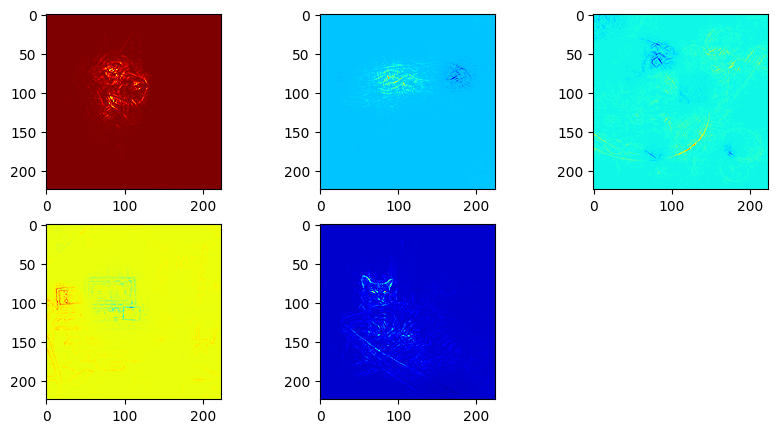

In [15]:
# Taking avg pool over grad cam to convert 2048*7*7 to 2048*1 tensor
m = torch.nn.AvgPool2d(kernel_size=(7, 7))
grad_cam_pool = m(grad_cam)

# output of last layer stored in c part
fc_grad = fc_grad.reshape(2048, -1)

plt.figure(figsize=(10, 5))

for i in range(5):
    # grad_cam_pool is 5*2048*1*1 tensor, taking its ith layer
    a = grad_cam_pool[i, :, :, :]

    img1 = torch.matmul(a[:, 0, 0], fc_grad).detach().reshape(7, 7)

    # scaliing of image
    img1 = cv2.resize(img1.numpy().astype(np.float32), (224, 224))

    # element-wise multiplication with images from guided backprop
    img1 = np.multiply(grad[i, :, :, :].numpy().sum(0), img1)

    plt.subplot(2, 3, i+1)
    plt.imshow(img1, cmap='jet')


### Question-2: SGD Update rule Variations

In [16]:
def f(x, y):
    return 10*x*x+y*y

# gradient w.r.t x


def gx(x):
    return 20*x

# gradient w.r.t y


def gy(y):
    return 2*y


#### Plot of $f(x,y)=10x^2+y^2$

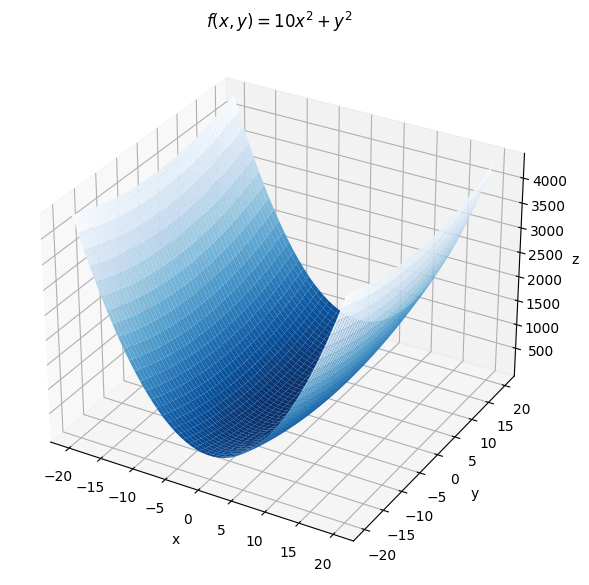

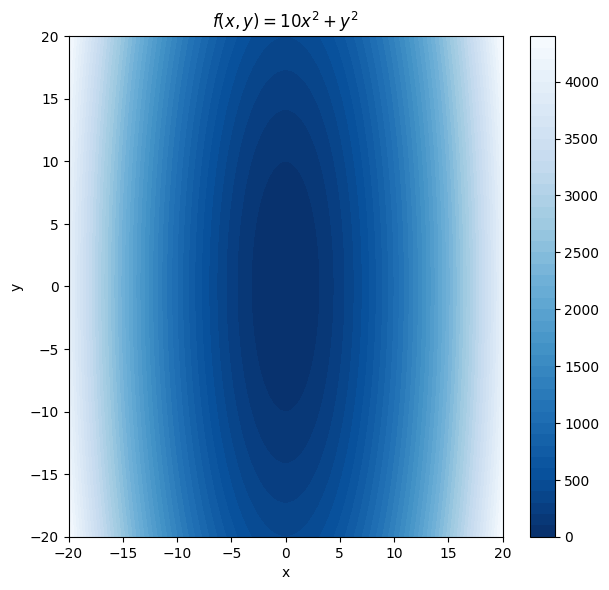

In [17]:
plt.figure(figsize=(7,7))

ax = plt.axes(projection='3d')
x = np.linspace(-20,20,1000)
y = np.linspace(-20,20,1000)
X,Y = np.meshgrid(x,y)
z = f(X,Y)
ax.set_title('$f(x,y)=10x^2+y^2$')
ax.set(xlabel='x',ylabel='y',zlabel='z')
ax.plot_surface(X, Y, z, cmap ='Blues_r')
plt.show()

fig,ax = plt.subplots(1,1,figsize=(7,6.5))
cp = ax.contourf(X, Y, z, levels=50, cmap='Blues_r')
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.colorbar(cp)
ax.set_title('$f(x,y)=10x^2+y^2$')
plt.show()

#### Vanilla SGD

In [18]:
max_epochs = 200
eta = 0.01

#initialize x and y
x,y = 10,10 
z_vanilla = []
x_vanilla = []
y_vanilla = []

for i in range(max_epochs):
    x = x - eta*gx(x)
    y = y - eta*gy(y)
    x_vanilla.append(x)
    y_vanilla.append(y)
    z_vanilla.append(f(x,y))

#### SGD with momentum

In [19]:
# initialize velocity for both parameters
vx = 0
vy = 0

# friction
rho = 0.9
eta = 0.01

#initialize x and y
x,y = 10,10
z_momentum = []
x_momentum = []
y_momentum = []

for i in range(max_epochs):
    vx = rho*vx + gx(x)
    vy = rho*vy + gy(y)
    x = x - eta*vx
    y = y - eta*vy
    x_momentum.append(x)
    y_momentum.append(y)
    z_momentum.append(f(x,y))

#### Nestrov Momentum

In [20]:
# initialize velocity for both parameters
vx = 0
vy = 0

# friction
rho = 0.9
eta = 0.01

#initialize x and y
x,y = 10,10
z_nestrov = []
x_nestrov = []
y_nestrov = []

for i in range(max_epochs):
    vx = rho*vx + (1 - rho)*gx(x - eta*vx)
    vy = rho*vy + (1 - rho)*gy(y - eta*vy)
    x = x - eta*vx
    y = y - eta*vy
    x_nestrov.append(x)
    y_nestrov.append(y)
    z_nestrov.append(f(x,y))

#### AdaGrad

In [21]:
# initialize x and y
x, y = 10, 10
z_ada = []
x_ada = []
y_ada = []

epsilon = 1e-6
eta = 2

gsq_x = 0.0
gsq_y = 0.0

for i in range(max_epochs):
    dx = gx(x)
    dy = gy(y)

    gsq_x += dx*dx
    gsq_y += dy*dy

    x = x - eta*dx/(np.sqrt(gsq_x)+epsilon)
    y = y - eta*dy/(np.sqrt(gsq_y)+epsilon)

    x_ada.append(x)
    y_ada.append(y)
    z_ada.append(f(x, y))


#### RMSProp

In [22]:
# initialize x and y
x, y = 10, 10
z_rms = []
x_rms = []
y_rms = []

eta = 2
epsilon = 1e-4
rho = 0.9

gsq_x = 0.0
gsq_y = 0.0

for i in range(max_epochs):
    dx = gx(x)
    dy = gy(y)

    gsq_x = rho*gsq_x + (1-rho)*dx*dx
    gsq_y = rho*gsq_y + (1-rho)*dy*dy

    x = x - eta*dx/(np.sqrt(gsq_x)+epsilon)
    y = y - eta*dy/(np.sqrt(gsq_y)+epsilon)

    x_rms.append(x)
    y_rms.append(y)
    z_rms.append(f(x, y))


#### GIF Visualization for $f(x,y)$ and number of iterations

In [23]:
!mkdir img2 

mkdir: cannot create directory ‘img2’: File exists


In [24]:
iter = np.arange(max_epochs)


def create_frame(t):
    fig = plt.figure(figsize=(8.5, 8.5))

    plt.plot(iter[:(t+1)], z_vanilla[:(t+1)], color='r')
    plt.plot(iter[t], z_vanilla[t], marker='o', color='r')

    plt.plot(iter[:(t+1)], z_momentum[:(t+1)], color='g')
    plt.plot(iter[t], z_momentum[t], marker='o', color='g')

    plt.plot(iter[:(t+1)], z_nestrov[:(t+1)], color='b')
    plt.plot(iter[t], z_nestrov[t], marker='o', color='b')

    plt.plot(iter[:(t+1)], z_ada[:(t+1)], color='y')
    plt.plot(iter[t], z_ada[t], marker='o', color='y')

    plt.plot(iter[:(t+1)], z_rms[:(t+1)], color='grey')
    plt.plot(iter[t], z_rms[t], marker='o', color='grey')

    plt.xlim((0, max_epochs))
    plt.ylim((-100, 1500))

    plt.xlabel('number of epochs', fontsize=14)
    plt.ylabel('$f(x,y)$', fontsize=14)
    plt.grid()
    plt.legend(['Vanilla SGD', 'Vanilla SGD', 'SGD with Momentum', 'SGD with Momentum',
               'Nestrov Momentum', 'Nestrov Momentum', 'AdaGrad', 'AdaGrad', 'RMSProp', 'RMSProp'])
    plt.savefig(f'img2/img_{t}.png', transparent=False, facecolor='white')

    plt.close()


In [25]:
time = np.arange(start=0, stop=max_epochs, step=2)

for t in time:
    create_frame(t)

frames = []
for t in time:
    image = imageio.v2.imread(f'img2/img_{t}.png')
    frames.append(image)

imageio.mimsave('1.gif', frames, fps=10)


<img src="1.gif" align="center">

#### GIF visualization for path within region (-20,20)

In [26]:
def create_frame2(t):
    fig, ax = plt.subplots(1, 1, figsize=(8.5, 7.5))
    cp = ax.contourf(X, Y, z, levels=50, cmap='Blues_r')
    fig.colorbar(cp)

    ax.scatter(x_vanilla[:t], y_vanilla[:t], marker='o',
               color='r', label='Vanilla SGD')

    ax.scatter(x_momentum[:t], y_momentum[:t], marker='o',
               color='g', label='SGD with Momentum')

    plt.scatter(x_nestrov[:t], y_nestrov[:t],
                marker='o', color='b', label='Nestrov')

    ax.scatter(x_ada[:t], y_ada[:t], marker='o', color='y', label='AdaGrad')

    ax.scatter(x_rms[:t], y_rms[:t], marker='o', color='grey', label='RMSProp')

    plt.xlim((-20, 20))
    plt.ylim((-20, 20))
    plt.xlabel('x', fontsize=14)
    plt.ylabel('y', fontsize=14)
    plt.legend()
    plt.savefig(f'img2/img_{t}.png', transparent=False, facecolor='white')

    plt.close()


In [27]:
time = np.arange(start=0, stop=max_epochs, step=2)

for t in time:
    create_frame2(t)

frames = []
for t in time:
    image = imageio.v2.imread(f'img2/img_{t}.png')
    frames.append(image)

imageio.mimsave('2.gif', frames, fps=10)


<img src="2.gif" width="750" align="center">


In [28]:
!rm -rf img2